In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"
CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0"

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 186
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,model=ref_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.75,0.3,0.05)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 509.92it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8166.23it/s]


absolute alignment indicates number: 147 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 78


In [3]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,model=tar_model,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 7879.41it/s]


In [ ]:
new_Rep = gen.generate_representation_by_cka(18, 1,500)

In [36]:
sys.path.append('..')
from CKA_utils.CKA import CKA, CudaCKA
ind = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates),axis=0)
np_cka = CKA()
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(ref_train_data[absolute_alignment_indicates],tar_train_data[absolute_alignment_indicates]))
print('CKA between diff+same subset is:',np_cka.kernel_CKA(ref_train_data[ind],tar_train_data[ind]))
print('CKA between adjusted vs tar diff+same subset is:',np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates], new_Rep),axis=0),tar_train_data[ind]))
print('CKA between adjusted vs ref diff+same subset is:',np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates], new_Rep),axis=0),ref_train_data[ind]))

print('CKA between init ref vs tar diff subset is:',np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates],tar_train_data[predict_label_diff_indicates]))
print('CKA between adjusted vs tar diff subset is:',np_cka.kernel_CKA(new_Rep,tar_train_data[predict_label_diff_indicates]))
print('CKA between adjusted vs ref diff subset is:',np_cka.kernel_CKA(new_Rep,ref_train_data[predict_label_diff_indicates]))

CKA between absolute alignmnet subset is: 0.9337511627863128
CKA between diff+same subset is: 0.9204746333019617
CKA between adjusted vs tar diff+same subset is: 0.9279185943299726
CKA between adjusted vs ref diff+same subset is: 0.9925973779460819
CKA between init ref vs tar diff subset is: 0.81107539820274
CKA between adjusted vs tar diff subset is: 0.9873767605465084
CKA between adjusted vs ref diff subset is: 0.8173425079609323


In [20]:
ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 8825.47it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

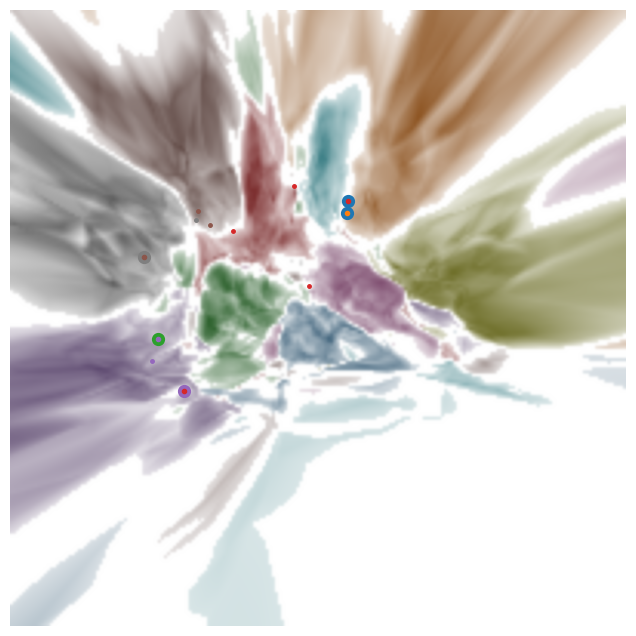

In [21]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [25]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )

In [31]:
representation = ref_provider.train_representation(200)
k = 0
inidcates = predict_label_diff_indicates
for i in range(len(inidcates)):
    index = inidcates[i]
    representation[index] = new_Rep[k]
    k = k + 1

In [41]:
X = representation[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

R = alignment.align_embeddings(X,Y,35000)

iteration 0, loss 23209166.366106074
iteration 1000, loss 1271.7471231875184
iteration 2000, loss 690.3644721084785
iteration 3000, loss 440.4249645287085
iteration 4000, loss 303.8957052715423
iteration 5000, loss 220.244949638691
iteration 6000, loss 165.187625656645
iteration 7000, loss 127.09795056933167
iteration 8000, loss 99.75358630455476
iteration 9000, loss 79.5519816267808
iteration 10000, loss 64.28070836097507
iteration 11000, loss 52.51698142269306
iteration 12000, loss 43.31125929360131
iteration 13000, loss 36.01019138598446
iteration 14000, loss 30.15256965083751
iteration 15000, loss 25.405644216899454
iteration 16000, loss 21.524783119783574
iteration 17000, loss 18.32715772141264
iteration 18000, loss 15.674135618144417
iteration 19000, loss 13.45923516807738
iteration 20000, loss 11.599721820648126
iteration 21000, loss 10.030642113147383
iteration 22000, loss 8.700521549153489
iteration 23000, loss 7.5682182606766455
iteration 24000, loss 6.600592291888468
iterati

In [39]:
X = representation[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

S = alignment.align_embeddings(Y,X,45000)

iteration 0, loss 22390525.757290713
iteration 1000, loss 927.9231332119542
iteration 2000, loss 616.4924217083425
iteration 3000, loss 450.3862646028199
iteration 4000, loss 348.5641127443749
iteration 5000, loss 280.33916811470465
iteration 6000, loss 231.65523167735293
iteration 7000, loss 195.277798004855
iteration 8000, loss 167.1368998556064
iteration 9000, loss 144.77769619113047
iteration 10000, loss 126.63395997631898
iteration 11000, loss 111.65917294112586
iteration 12000, loss 99.12673907888419
iteration 13000, loss 88.51577187309879
iteration 14000, loss 79.44268420309204
iteration 15000, loss 71.61850993422169
iteration 16000, loss 64.8213115150589
iteration 17000, loss 58.877774435626534
iteration 18000, loss 53.6505887942523
iteration 19000, loss 49.02958797163164
iteration 20000, loss 44.925392829868855
iteration 21000, loss 41.264767143523265
iteration 22000, loss 37.987166877532395
iteration 23000, loss 35.0421383078262
iteration 24000, loss 32.3873300255603
iteratio

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


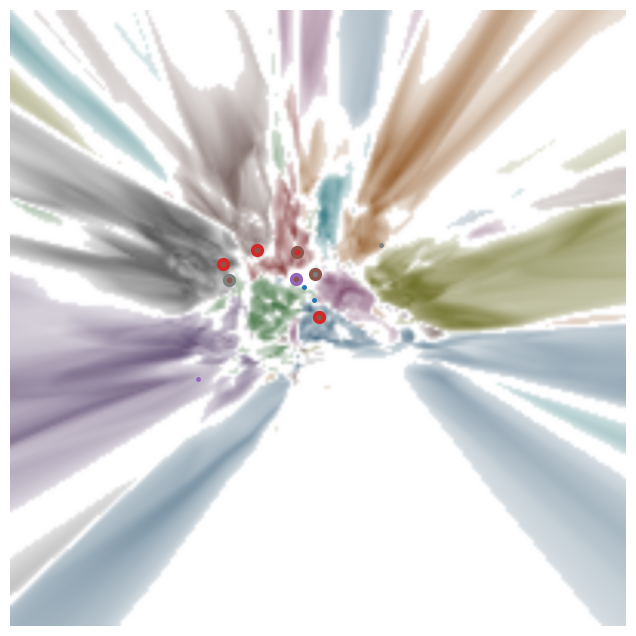

In [42]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,S), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8235.62it/s]


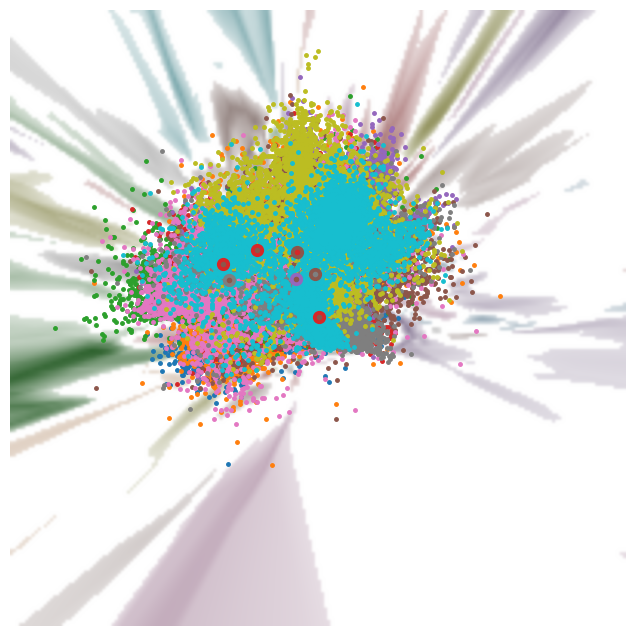

In [44]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,S), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))